In [67]:
pip install -q pandas ipywidgets tables bokeh

Note: you may need to restart the kernel to use updated packages.


# Setup
Run this every time

In [2]:
import glob
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import pydash 
import ipywidgets as widgets
from concurrent.futures import ThreadPoolExecutor

from IPython.display import display, HTML
from matplotlib import pyplot as plt
from typing import Any, List
from dataclasses import dataclass
from pathlib import Path
from tensorflow.keras import layers

# Set memory growth to true, doing means that models will not take up 100% of the GPU memory but may also run slower
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
@dataclass
class DataFile:
    '''
    This is a utiltiy class that takes the .h5 files created by deeplabcut 
    '''
    filename: str
    df: pd.DataFrame = None
    label: int = None
    nfeatures: int = -1
    
    def __post_init__(self):
        self.df = pd.read_hdf(self.filename)
        self.label = int('lps' in self.filename) # Label is 1 is the filename contains "lps"
        self.nfeatures = self.df.shape[1]
        
    def sample_evenly(self, time, step):
        if time == 1:
            start_indices = np.arange(0, self.df.shape[0] - time, step)
        else:
            start_indices = np.arange(0, self.df.shape[0] - time, step)
        X = np.zeros(shape=(len(start_indices), time, self.df.shape[1]))
        y = np.ones(shape=(len(start_indices))) * self.label
        traces = []
        
        for index, start in enumerate(start_indices):
            X[index] = self.df.loc[start : start + time - 1].values
            traces.append(SampleTraceInformation(self.filename, start, time))
        return Sample(X, y, traces)
    
@dataclass 
class Sample:
    '''
    Utility class that stores X, y, and trace information. Trace information can be used to find 
    the original file/frames that the associated X and y values were taken from. This class also 
    provides the useful funcationality of allowing samples to be summed together, which
    concatenates their data.
    '''
    X: Any
    y: Any
    trace: Any
        
    def __add__(self, other):
        return Sample(
            np.concatenate([self.X, other.X], axis=0),
            np.concatenate([self.y, other.y], axis=0),
            self.trace + other.trace
        )
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)
        
@dataclass 
class SampleTraceInformation:
    '''
    A dataclass that holds information to track X and y values back to the files and frames they came from
    '''
    file: str 
    start: int
    length: int
        
        
class DisplayEpochCallback(tf.keras.callbacks.Callback):
    '''
    Simple callback that logs an experiment's epoch to an output widget
    '''
    def __init__(self, exp):
        self.experiment = exp
        
    def on_epoch_begin(self, epoch, logs=None):
        self.experiment.display_epoch(f"Epoch: {epoch}/{self.experiment.run_params['epochs']}")
        
@dataclass
class Experiment:
    '''
    The experiment class generates and fits models according to the parameters given to it.
    It displays data using IPython widgets
    '''
    name: str
    train: Any
    test: Any
    model_generator : Any 
    repeat: int = 1
    model_params : dict = None
    run_params : dict = None
    compile_params : dict = None
        
    def __post_init__(self):
        self.models = []
        self.histories = []
        self.create_outputs()
            
    def run(self):
        self.display_name(f"Experiment: {self.name}")
        for run_count in range(self.repeat):
            self.display_run(f"Run: {run_count}/{self.repeat}")
            model = self.model_generator(self, **self.model_params)
            model.compile(**self.compile_params)
            self.histories.append(
                model.fit(
                    tf.data.Dataset.from_tensors((self.train.X, self.train.y)), 
                    validation_data=(
                        tf.data.Dataset.from_tensors((self.test.X, self.test.y))
                    ), 
                    **self.run_params
                )
            )
            self.models.append(model)

    def average_histories(self, key):
        avg = np.array([pydash.get(history.history, key) for history in self.histories])
        avg = np.sum(avg, axis=0) / len(self.histories)
        return avg
        
    def create_outputs(self):
        self.output_experiment_name = widgets.Text(disabled=True)
        self.output_experiment_run = widgets.Text(disabled=True)
        self.output_experiment_epoch = widgets.Text(disabled=True)
        
        self.outputs = widgets.HBox([
            self.output_experiment_name,
            self.output_experiment_run,
            self.output_experiment_epoch
        ], layout=widgets.Layout(width='auto'))
        
        # Insert the Epoch Callback
        output_epoch_callback = DisplayEpochCallback(exp=self)
        if 'callbacks' not in self.run_params:
            self.run_params['callbacks'] = []
        self.run_params['callbacks'] += [output_epoch_callback]
        
    def display_name(self, text):
        self.output_experiment_name.value = text
        
    def display_run(self, text):
        self.output_experiment_run.value = text
        
    def display_epoch(self, text):
        self.output_experiment_epoch.value = text

1 Physical GPUs, 1 Logical GPUs


In [2]:
# This is the folder that contains the *.h5 files produced by DLC analysis 
data_dir = Path('/repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000')

# Spliting the data into training and test files. Here we split based on the rat
train_files = [DataFile(f) for f in glob.glob(str(data_dir / 'rat[1-7]*.h5'))]
# val_files = [DataFile(f) for f in glob.glob(str(data_dir / 'rat[6-7]*.h5'))] 
test_files = [DataFile(f) for f in glob.glob(str(data_dir / 'rat[8-9]*.h5'))] 

time = 10 * 24
step = 5 * 24
train = sum([data_file.sample_evenly(time, step) for data_file in train_files])
test = sum([data_file.sample_evenly(time, step) for data_file in test_files])

# Experiment 1 : Learning Rates

In [ ]:
def scheduler_strategy1(epoch, lr):
    if epoch < 100:
        return 0.001
    elif epoch < 500:
        return 0.0001
    else:
        return 0.00001
    
def scheduler_strategy2(epoch, lr):
    if epoch < 100:
        return 0.001 - (0.001 - 0.0001) / 100 * epoch
    else:
        return 0.0001
    
def generate_simple_model(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

epochs = 1000
all_run_params = [
    {
        'epochs': epochs,
        'verbose': 0
    },
    {
        'epochs': epochs,
        'verbose': 0
    },
    {
        'epochs': epochs,
        'verbose': 0,
        'callbacks': [tf.keras.callbacks.LearningRateScheduler(scheduler_strategy1)]
    },
    {
        'epochs': epochs,
        'verbose': 0,
        'callbacks': [[tf.keras.callbacks.LearningRateScheduler(scheduler_strategy1)]]
    },
]

rho = 0.9
momentum = 0.2
all_compile_params = [
    {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.0001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    },
    {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    },
    {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.0001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    },
    {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.0001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    },
]

repeat = 5
experiments = []
labels = ['lrate=0.0001', 'lrate=0.001', 'Strategy 1 ', 'Strategy 2']
for count, (run_params, compile_params) in enumerate(zip(all_run_params, all_compile_params)):
    experiment = Experiment(
        labels[count], 
        repeat=repeat, 
        train=train, 
        test=test, 
        model_generator=generate_simple_model, 
        compile_params=compile_params, 
        run_params=run_params, 
        model_params={}
    )
    experiments.append(experiment)
    
# Create Displays
display(widgets.VBox([experiment.outputs for experiment in experiments]))

# Create Experiments
with ThreadPoolExecutor() as executor:
    for experiment in experiments:
#         print(experiment.name)
#         print(experiment.run_params)
        executor.submit(experiment.run)
#     experiment.run()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Learning Rate Strategies: Train Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    plt.plot(experiment.average_histories('binary_accuracy'), label=experiment.name)
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Learning Rate Strategies: Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    plt.plot(experiment.average_histories('val_binary_accuracy'), label=experiment.name)
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Learning Rate Strategies: Top-3 Results on Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for experiment in experiments:
    top_n = 2
    top_n_histories = sorted(experiment.histories, key=lambda x: sum(x.history['val_binary_accuracy'][-10:]), reverse=True)[:top_n]
    
    avg = np.array([pydash.get(history.history, 'val_binary_accuracy') for history in top_n_histories])
    avg = np.sum(avg, axis=0) / len(top_n_histories)
    plt.plot(avg, label=experiment.name)
    plt.legend()
    
plt.savefig('2020-08-08_learning-strategies_fig3.png')

In [ ]:
def predict(model, X, y):
    p = model.predict(X)
    p[p >= 0.5] = 1
    p[p < 0.5] = 0
    return np.sum(p.reshape(-1) == y, axis=0) / p.shape[0]
     
    
df = pd.DataFrame(
    data = [[predict(model, experiment.test.X, experiment.test.y) for model in experiment.models] for experiment in experiments],
    columns = [f"Run {run}" for run in range(experiments[0].repeat)],
    index = [experiment.name for experiment in experiments]
)

from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.models import ColumnDataSource
from bokeh.io import show

columns = [TableColumn(field=column, title=column) for column in df.columns] # bokeh columns
data_table = DataTable(columns=columns, source=ColumnDataSource(df)) # bokeh table
show(data_table)

# Experiment 2: Layer Depth 

In [3]:
def model1(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

def model2(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

def model3(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

epochs = 500
def gen_run_params():
    return {
        'epochs': epochs,
        'verbose': 0
    }

rho = 0.9
momentum = 0.2
def gen_compile_params():
    return {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    }

repeat = 10
experiments = []
labels = ['1 LSTM Layer', '2 LSTM Layers', '3 LSTM Layers']
for count, model_gen in enumerate([model1, model2, model3]):
    experiment = Experiment(
        labels[count], 
        repeat=repeat, 
        train=train, 
        test=test, 
        model_generator=model_gen, 
        compile_params=gen_compile_params(), 
        run_params=gen_run_params(), 
        model_params={}
    )
    experiments.append(experiment)
    
# Create Displays
display(widgets.VBox([experiment.outputs for experiment in experiments]))

# Create Experiments
with ThreadPoolExecutor() as executor:
    for experiment in experiments:
        executor.submit(experiment.run)

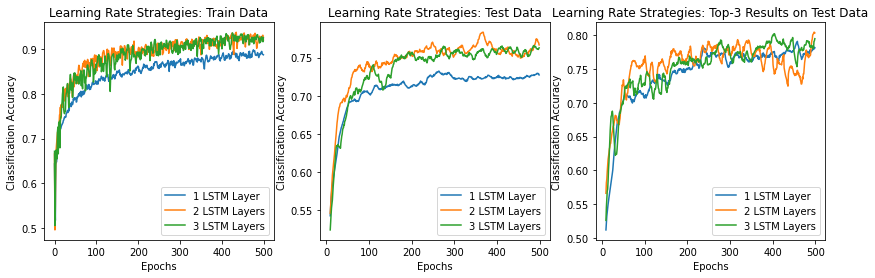

In [4]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.title("Learning Rate Strategies: Train Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    plt.plot(experiment.average_histories('binary_accuracy'), label=experiment.name)
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Learning Rate Strategies: Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    l = experiment.average_histories('val_binary_accuracy')
    df = pd.DataFrame(l).rolling(10).mean()
    plt.plot(df, label=experiment.name)
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Learning Rate Strategies: Top-3 Results on Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for experiment in experiments:
    top_n = 2
    top_n_histories = sorted(experiment.histories, key=lambda x: sum(x.history['val_binary_accuracy'][-10:]), reverse=True)[:top_n]
    avg = np.array([pydash.get(history.history, 'val_binary_accuracy') for history in top_n_histories])
    avg = np.sum(avg, axis=0) / len(top_n_histories)
    avg = pd.Series(avg).rolling(10).mean()
    plt.plot(avg, label=experiment.name)
    plt.legend()
    
plt.savefig('2020-08-08_basic-models_fig4.png')

# Experiment 3: Time

Comment: I'm noticing in the graphs the lower learning rate seems to flatten our earlier. Is this because it got caught in a local minima?

In [4]:
def model(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

epochs = 1000
def get_run_params():
    return {
        'epochs': epochs,
        'verbose': 0
    }

rho = 0.9
momentum = 0.2
def get_compile_params():
    return {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    }

repeat = 10
experiments = []
times = [1, 3, 24, 10*24, 60*24]
time_step = 5*24
for count, time in enumerate(times):
    train = sum([data_file.sample_evenly(time, time_step) for data_file in train_files])
    test = sum([data_file.sample_evenly(time, time_step) for data_file in test_files])
    experiment = Experiment(
        f"frames={time}", 
        repeat=repeat, 
        train=train, 
        test=test, 
        model_generator=model, 
        compile_params=get_compile_params(), 
        run_params=get_run_params(), 
        model_params={}
    )
    experiments.append(experiment)
    
# Create Displays
display(widgets.VBox([experiment.outputs for experiment in experiments]))

# Create Experiments
with ThreadPoolExecutor(max_workers=3) as executor:
    for experiment in experiments:
#         experiment.run()/
        executor.submit(experiment.run)

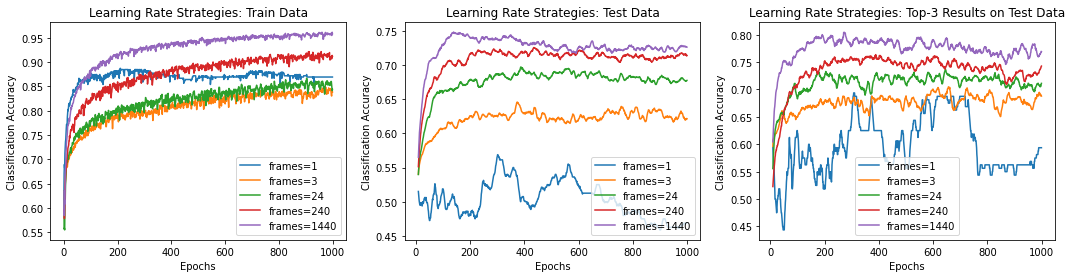

In [11]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Learning Rate Strategies: Train Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    plt.plot(experiment.average_histories('binary_accuracy'), label=experiment.name)
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Learning Rate Strategies: Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    l = experiment.average_histories('val_binary_accuracy')
    df = pd.DataFrame(l).rolling(10).mean()
    plt.plot(df, label=experiment.name)
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Learning Rate Strategies: Top-3 Results on Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for experiment in experiments:
    top_n = 2
    top_n_histories = sorted(experiment.histories, key=lambda x: sum(x.history['val_binary_accuracy'][-10:]), reverse=True)[:top_n]
    avg = np.array([pydash.get(history.history, 'val_binary_accuracy') for history in top_n_histories])
    avg = np.sum(avg, axis=0) / len(top_n_histories)
    avg = pd.Series(avg).rolling(10).mean()
    plt.plot(avg, label=experiment.name)
    plt.legend()
    
plt.savefig('2020-08-08_time-compare_lrate1e-3_corrected.png')

[46, 51, 52, 53, 54, 61, 63, 64, 66, 68, 69, 73, 83, 90, 190, 235, 262]
[190, 235, 83, 64, 51, 46, 73, 90, 68, 61, 54, 262, 66, 52, 53, 63, 69]
190 7920 /repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000/rat8-lps1DLC_resnet50_MousePoseJul21shuffle1_1030000.h5
235 6000 /repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000/rat9-control1DLC_resnet50_MousePoseJul21shuffle1_1030000.h5
83 10080 /repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000/rat9-lps1DLC_resnet50_MousePoseJul21shuffle1_1030000.h5
64 5520 /repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000/rat9-lps1DLC_resnet50_MousePoseJul21shuffle1_1030000.h5
51 2400 /repos/gs/rat-emotion/dlc/analyzed-videos/2020-07-25_DLC_resnet50_MousePoseJul21shuffle1_1030000/rat9-lps1DLC_resnet50_MousePoseJul21shuffle1_1030000.h5
46 1200 /repos/gs/rat-emotion/dlc/analyzed-v

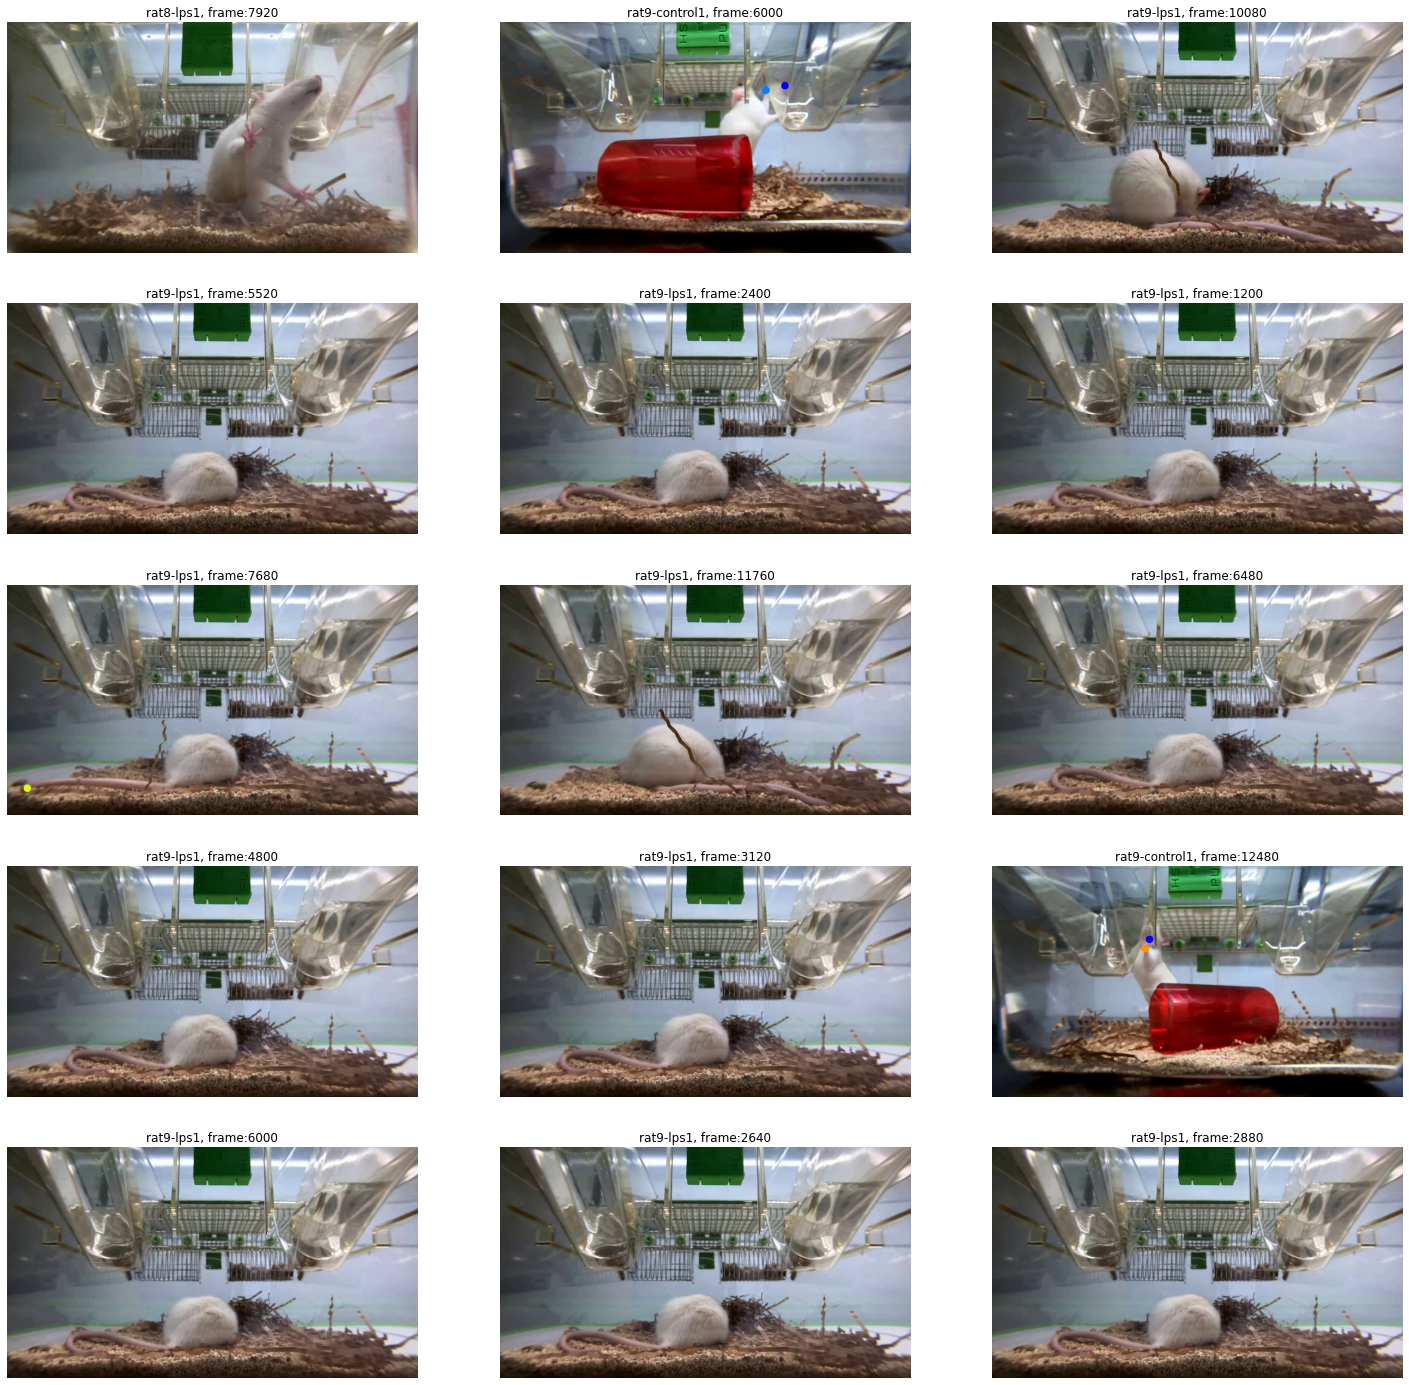

<Figure size 432x288 with 0 Axes>

In [16]:
import re
import os
import cv2
import random

video_dir = Path('/repos/gs/rat-emotion/videos/24fps')
for experiment in experiments[1:]:
    predictions = [model.predict(experiment.test.X).reshape(-1) for model in experiment.models]
    binarize = np.vectorize(lambda x: 1 if x >= 0.5 else 0)  
    correct = [binarize(prediction) == experiment.test.y for prediction in predictions]
    correct = np.sum(np.array(correct), axis=0)

    plt.figure(figsize=(25, 25))
    difficult = np.argwhere(correct <= 1)
    difficult = [l[0] for l in difficult]
    print(difficult)
    random.shuffle(difficult)
    print(difficult)
    
    for count in range(15):
        idx = difficult[count]
        trace = experiment.test.trace[idx]
        print(idx, trace.start, trace.file)
        head, tail = os.path.split(trace.file)
        match = re.match(r'(?P<video>rat\d+\-[a-z]+\d+).*', tail)
        video_name = match.groupdict()['video']
        video_path = glob.glob(str(data_dir / video_name) + '*.mp4')[0]
        assert os.path.exists(video_path)
        
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, trace.start)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 3, count+1)
        plt.axis('off')
        plt.imshow(frame)
        plt.title(f"{video_name}, frame:{trace.start}")
        cap.release()
        
    break
plt.show()
plt.savefig('trace-incorrect_fig2.png')

# Experiment 4: Dropout

In [ ]:
time = 10 * 24
train = sum([data_file.sample_evenly(time, 10 * 24) for data_file in train_files])
test = sum([data_file.sample_evenly(time, 10 * 24) for data_file in test_files])

epochs = 5000
def get_run_params():
    return {
        'epochs': epochs,
        'verbose': 0
    }

rho = 0.9
momentum = 0.2
def get_compile_params():
    return {
        'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.001),
        'loss': tf.keras.losses.BinaryCrossentropy(),
        'metrics': [tf.keras.metrics.BinaryAccuracy()]
    }

def model1(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.Dropout(0.5),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.5),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])


def model2(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

def model3(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])

def model4(experiment):
    return tf.keras.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=experiment.train.X.shape[1:]),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

epochs = 10000
run_params ={
    'epochs': epochs,
    'verbose': 0
}

rho = 0.9
momentum = 0.2
compile_params = {
    'optimizer': tf.keras.optimizers.RMSprop(rho=rho, momentum=momentum, learning_rate=0.0001),
    'loss': tf.keras.losses.BinaryCrossentropy(),
    'metrics': [tf.keras.metrics.BinaryAccuracy()]
}

repeat = 10
experiments = []
labels = ['Dropout after each layer', 'Dropout after LSTM layers', 'Dropout after Dense layer', 'No dropout']
for count, model_gen in enumerate([model1, model2, model3, model4]):
    experiment = Experiment(
        labels[count], 
        repeat=repeat, 
        train=train, 
        test=test, 
        model_generator=model_gen, 
        compile_params=get_compile_params(), 
        run_params=get_run_params(), 
        model_params={}
    )
    experiments.append(experiment)
    
# Create Displays
display(widgets.VBox([experiment.outputs for experiment in experiments]))

# Create Experiments
with ThreadPoolExecutor() as executor:
    for experiment in experiments:
#         experiment.run()
        executor.submit(experiment.run)

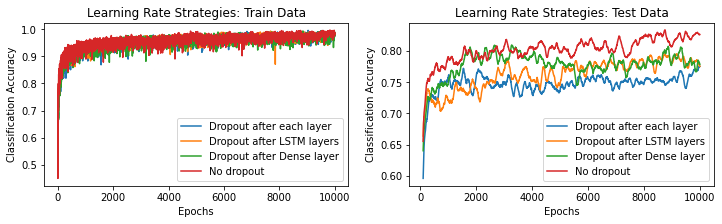

In [12]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.title("Learning Rate Strategies: Train Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    plt.plot(experiment.average_histories('binary_accuracy'), label=experiment.name)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Learning Rate Strategies: Test Data")
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
for idx, experiment in enumerate(experiments):
    l = experiment.average_histories('val_binary_accuracy')
    df = pd.DataFrame(l).rolling(100).mean()
    plt.plot(df, label=experiment.name)
plt.legend()
    
plt.savefig('2020-08-08_dropout_fig2-10k.png')